In [1]:
import _pickle as cPickle

In [2]:
def unpickle(file):
    with open(file,'rb') as file_reader:
        _dict=cPickle.load(file_reader,encoding='bytes')
    return _dict


In [3]:
filepath='cifar-100-python'
train= unpickle(os.path.join(filepath, "train"))
test= unpickle(os.path.join(filepath, "train"))
meta= unpickle(os.path.join(filepath, "meta"))


In [7]:
train[b'data'].shape

(50000, 3072)

In [14]:
meta.keys()

dict_keys([b'fine_label_names', b'coarse_label_names'])

In [15]:
import numpy as np
import pandas as pd




In [56]:
X_train=np.asarray(train[b'data'])
X_train_orig=X_train.reshape(50000,3,32,32).transpose(0,2,3,1).astype("uint8")
#X_train_orig=X_train.reshape(X_train.shape[0], -1).T/255
X_train_orig.shape


(50000, 32, 32, 3)

In [58]:
from imgaug import augmenters as aug

_seq=aug.Sequential([
    aug.Fliplr(0.5),
    aug.CropAndPad(px=(-2, 2),sample_independently=True,pad_mode=["constant", "edge"]),
    aug.Affine(shear=(-10, 10),mode = ['symmetric','wrap']),#48
    aug.Add((-5, 5)),
    aug.Multiply((0.8, 1.2)),
],random_order=True)


In [59]:
augmented_X1= _seq.augment_images(X_train_orig)

In [60]:
augmented_X1.shape

(50000, 32, 32, 3)

In [61]:
all_train=[]
all_train.extend(X_train_orig)
all_train.extend(augmented_X1/255)

In [62]:
all_train_labels=[]
all_train_labels.extend(train[b'fine_labels'])
all_train_labels.extend(train[b'fine_labels'])

In [63]:
import random

all_train_shuffled,all_train_labels_shuffled=[],[]
combined=list(zip(all_train, all_train_labels))
random.shuffle(combined)

In [64]:
all_train_shuffled[:],all_train_labels_shuffled[:]=zip(*combined)

In [65]:
num_classes=100
all_train_shuffled=np.asarray(all_train_shuffled)
all_train_shuffled.shape

(100000, 32, 32, 3)

In [66]:
def one_hot_encode(vec,vals=num_classes):
    n = len(vec)
    Y = np.zeros((n, vals))
    Y[range(n), vec] = 1
    return Y

all_train_labels_shuffled=one_hot_encode(all_train_labels_shuffled,num_classes)


In [67]:
all_train_labels_shuffled.shape

(100000, 100)

In [68]:
X_train_shuffled=all_train_shuffled
Y_train_shuffled=all_train_labels_shuffled

In [69]:
X_test=np.asarray(test[b'data'])
X_test_shuffled=X_test.reshape(len(X_test),3,32,32).transpose(0,2,3,1)/255
Y_test_shuffled=one_hot_encode(test[b'fine_labels'],num_classes)

In [70]:
X_test_shuffled.shape

(50000, 32, 32, 3)

In [71]:
Y_test_shuffled.shape

(50000, 100)

In [72]:
X_train_shuffled.shape

(100000, 32, 32, 3)

In [73]:
Y_train_shuffled.shape

(100000, 100)

In [74]:
from keras import layers
from keras.layers import Input,Add,Dense,Activation,ZeroPadding2D,BatchNormalization,Flatten,Conv2D,AveragePooling2D,MaxPooling2D,GlobalMaxPooling2D
from keras.models import Model,load_model

In [75]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [76]:
def ResNet_IdentityBlock(Input_X, f, filters, stage, block):
    
    conv_name_base= 'RES' + str(stage) + block + '_branch'
    bn_name_base= 'BN' + str(stage) + block + '_branch'

    F1,F2,F3=filters

    Shortcut_X=Input_X

    Input_X=Conv2D(
        filters=F1,
        kernel_size=(1,1),
        strides=(1,1),
        padding="valid",
        name=conv_name_base+'2a',
        kernel_initializer="glorot_uniform"
    )(Input_X)
    Input_X=BatchNormalization(
        axis=3,
        name=bn_name_base+'2a'
    )(Input_X)
    Input_X=Activation('relu')(Input_X)

    Input_X=Conv2D(
        filters=F2,
        kernel_size=(f,f),
        strides=(1,1),
        padding="same",
        name=conv_name_base+'2b',
        kernel_initializer="glorot_uniform"
    )(Input_X)
    Input_X=BatchNormalization(
        axis=3,
        name=bn_name_base+'2b'
    )(Input_X)
    Input_X=Activation('relu')(Input_X)

    Input_X=Conv2D(
        filters=F3,
        kernel_size=(1,1),
        strides=(1,1),
        padding="valid",
        name=conv_name_base+'2c',
        kernel_initializer="glorot_uniform"
    )(Input_X)
    Input_X=BatchNormalization(
        axis=3,
        name=bn_name_base+'2c'
    )(Input_X)

    Input_X=Add()([Shortcut_X,Input_X])
    Input_X=Activation('relu')(Input_X)

    return Input_X
    




In [77]:
def ResNet_ConvolutionBlock(Input_X,f,filters,stage,block,s=2):
    
    conv_name_base= 'RES' + str(stage) + block + '_branch'
    bn_name_base= 'BN' + str(stage) + block + '_branch'

    F1,F2,F3=filters

    Shortcut_X=Input_X

    Input_X=Conv2D(
        filters=F1,
        kernel_size=(1,1),
        strides=(s,s),
        name=conv_name_base+'2a',
        kernel_initializer="glorot_uniform"
    )(Input_X)
    Input_X=BatchNormalization(
        axis=3,
        name=bn_name_base+'2a'
    )(Input_X)
    Input_X=Activation('relu')(Input_X)

    Input_X=Conv2D(
        filters=F2,
        kernel_size=(f,f),
        strides=(1,1),
        padding="same",
        name=conv_name_base+'2b',
        kernel_initializer="glorot_uniform"
    )(Input_X)
    Input_X=BatchNormalization(
        axis=3,
        name=bn_name_base+'2b'
    )(Input_X)
    Input_X=Activation('relu')(Input_X)

    Input_X=Conv2D(
        filters=F3,
        kernel_size=(1,1),
        strides=(1,1),
        padding="valid",
        name=conv_name_base+'2c',
        kernel_initializer="glorot_uniform"
    )(Input_X)
    Input_X=BatchNormalization(
        axis=3,
        name=bn_name_base+'2c'
    )(Input_X)

    Shortcut_X=Conv2D(
        filters=F3,
        kernel_size=(1,1),
        strides=(s,s),
        padding="valid",
        name=conv_name_base+'1',
        kernel_initializer="glorot_uniform"
    )(Shortcut_X)
    Shortcut_X=BatchNormalization(
        axis=3,
        name=bn_name_base+'1'
    )(Shortcut_X)


    Input_X=Add()([Input_X,Shortcut_X])
    Input_X=Activation('relu')(Input_X)

    return Input_X


In [78]:
def ResNet50(input_shape=(32,32,3),classes=100):
    """
    Implementation of the popular ResNet50 the following architecture:

    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    """

    X_Input=Input(shape=input_shape)

    Input_X=ZeroPadding2D((3,3))(X_Input)

    #Stage-1
    #7*7*64
    Input_X=Conv2D(
        filters=64,
        kernel_size=(7,7),
        strides=(2,2),
        name='conv1',
        kernel_initializer="glorot_uniform"
    )(Input_X)
    Input_X=BatchNormalization(
        axis=3,
        name='bn_conv1'
    )(Input_X)
    Input_X=Activation('relu')(Input_X)
    Input_X=MaxPooling2D(
        pool_size=(3,3),
        strides=(2,2)
    )(Input_X)

    #Stage-2
    Input_X=ResNet_ConvolutionBlock(
        Input_X=Input_X,
        f=3,
        filters=[64,64,256],
        stage=2,
        block='a',
        s=1
    )
    Input_X=ResNet_IdentityBlock(
        Input_X=Input_X,
        f=3,
        filters=[64,64,256],
        stage=2,
        block='b',
    )
    Input_X=ResNet_IdentityBlock(
        Input_X=Input_X,
        f=3,
        filters=[64,64,256],
        stage=2,
        block='c',
    )

    #stage-3
    Input_X=ResNet_ConvolutionBlock(
        Input_X=Input_X,
        f=3,
        filters=[128,128,512],
        stage=3,
        block='a',
        s=2
    )
    Input_X=ResNet_IdentityBlock(
        Input_X=Input_X,
        f=3,
        filters=[128,128,512],
        stage=3,
        block='b',
    )
    Input_X=ResNet_IdentityBlock(
        Input_X=Input_X,
        f=3,
        filters=[128,128,512],
        stage=3,
        block='c',
    )
    Input_X=ResNet_IdentityBlock(
        Input_X=Input_X,
        f=3,
        filters=[128,128,512],
        stage=3,
        block='d',
    )

    #stage-4
    Input_X=ResNet_ConvolutionBlock(
        Input_X=Input_X,
        f=3,
        filters=[256,256,1024],
        stage=4,
        block='a',
        s=2
    )
    Input_X=ResNet_IdentityBlock(
        Input_X=Input_X,
        f=3,
        filters=[256,256,1024],
        stage=4,
        block='b',
    )
    Input_X=ResNet_IdentityBlock(
        Input_X=Input_X,
        f=3,
        filters=[256,256,1024],
        stage=4,
        block='c',
    )
    Input_X=ResNet_IdentityBlock(
        Input_X=Input_X,
        f=3,
        filters=[256,256,1024],
        stage=4,
        block='d',
    )
    Input_X=ResNet_IdentityBlock(
        Input_X=Input_X,
        f=3,
        filters=[256,256,1024],
        stage=4,
        block='e',
    )
    Input_X=ResNet_IdentityBlock(
        Input_X=Input_X,
        f=3,
        filters=[256,256,1024],
        stage=4,
        block='f',
    )

    #stage-5
    Input_X=ResNet_ConvolutionBlock(
        Input_X=Input_X,
        f=3,
        filters=[512,512,2048],
        stage=5,
        block='a',
        s=2
    )
    Input_X=ResNet_IdentityBlock(
        Input_X=Input_X,
        f=3,
        filters=[512,512,2048],
        stage=5,
        block='b',
    )
    Input_X=ResNet_IdentityBlock(
        Input_X=Input_X,
        f=3,
        filters=[512,512,2048],
        stage=5,
        block='c',
    )

    Input_X=AveragePooling2D(
        pool_size=(2,2),
        padding='same'
    )(Input_X)

    Input_X=Flatten()(Input_X)
    Input_X=Dense(
        classes,
        activation='softmax',
        name='fc'+str(classes),
        kernel_initializer="glorot_uniform"
    )(Input_X)

    model=Model(inputs=X_Input,outputs=Input_X,name='ResNet50')

    return model

In [79]:
model=ResNet50(input_shape=(32, 32, 3), classes = 100)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [95]:
model.save('myResNet50.h5')

In [85]:
from keras.callbacks import CSVLogger
csv_logger=CSVLogger(
    'log.csv',
    append=True,
    separator=';'
)

In [86]:
model.fit(X_train_shuffled, Y_train_shuffled, epochs = 20, batch_size = 64,callbacks=[csv_logger])

Epoch 1/20
1563/1563 [==============================] - 7521s 5s/step - loss: 2.9504 - accuracy: 0.2796
Epoch 2/20
1563/1563 [==============================] - 7541s 5s/step - loss: 2.8202 - accuracy: 0.3044
Epoch 3/20
1563/1563 [==============================] - 34540s 22s/step - loss: 2.4941 - accuracy: 0.3611
Epoch 4/20
1563/1563 [==============================] - 7845s 5s/step - loss: 2.3381 - accuracy: 0.3906
Epoch 5/20
1563/1563 [==============================] - 7995s 5s/step - loss: 2.1628 - accuracy: 0.4282
Epoch 6/20
1563/1563 [==============================] - 8172s 5s/step - loss: 1.8987 - accuracy: 0.4869
Epoch 7/20
1563/1563 [==============================] - 7989s 5s/step - loss: 1.6172 - accuracy: 0.5490
Epoch 8/20
1563/1563 [==============================] - 7838s 5s/step - loss: 1.3105 - accuracy: 0.6249
Epoch 9/20
1563/1563 [==============================] - 11535s 7s/step - loss: 1.0776 - accuracy: 0.6860
Epoch 10/20
1563/1563 [==============================] - 3480

In [87]:
preds = model.evaluate(X_test_shuffled, Y_test_shuffled)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

1563/1563 [==============================] - 211s 135ms/step - loss: 1.0487 - accuracy: 0.9671
Loss = 1.0487356185913086
Test Accuracy = 0.9670799970626831


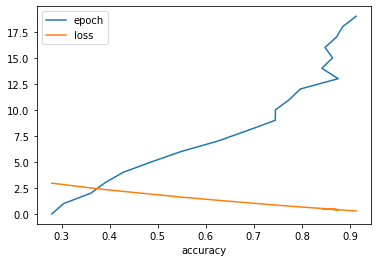

In [94]:
import matplotlib.pyplot as plt

filename='log.csv'
df=pd.read_csv(filename,delimiter=';')
plot = df.plot.line('accuracy')
plt.show()


In [96]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [ ]:
history= model.fit(X_train_shuffled, Y_train_shuffled, epochs = 20, batch_size = 64,callbacks=[csv_logger])